In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

def rough_plot(in_list, num_group):
    rough_list = list()
    tmp_sum = 0
    
    for i in range(1, len(in_list)):
        tmp_sum += in_list[i]
    
        if(i%num_group == num_group-1):
            rough_list.append(tmp_sum / num_group)
            tmp_sum = 0
            
    plt.plot(rough_list)

In [3]:
import sys

def next_state(state, action, action_level):
    next_state = state.copy()
    if (action > 2*action_level) or action < 0:
        print("action = ", action)
        sys.exit("error, action undefined! nxt")

    if action >= 1 and action <= action_level:
        # then buy
        
        if state['HandCash'] > 0:
            next_state['HandCash'] = state['HandCash']*(1 - action/action_level)
            next_state['NumStock'] = state['NumStock'] + \
                                     (state['HandCash']/state['StockPrice'])*(action/action_level)

    elif action >= (action_level + 1) and action <= (action_level + action_level) :
        # then sell
        
        if state['NumStock'] > 0:
            next_state['NumStock'] = state['NumStock']*(1 - (action-action_level)/action_level)
            next_state['HandCash'] = state['HandCash'] + \
                                     (state['StockPrice']*state['NumStock'])*((action-action_level)/action_level)
    
    return next_state


def reward(state, init_invest):
    return (state['NumStock']*state['StockPrice'] + state['HandCash']) - init_invest

def my_reward(curr, last):
    return (curr['NumStock']*curr['StockPrice'] + curr['HandCash']) - \
           (last['NumStock']*last['StockPrice'] + last['HandCash'])

In [4]:


def feature_5_conti(k_today, d_today, k_yestd, d_yestd, action, action_level):
    inter = (k_yestd+d_yestd+k_today+d_today)/4
    sinter = inter/100 # scaled inter
    if((k_yestd > d_yestd and k_today < d_today and inter > 50) or \
       (k_yestd < d_yestd and k_today > d_today and inter < 50)):
        # saction= sell all:1, sell:1~0.5, hold:0.5, buy:0.5~0, buy all:0
        # the diff btw saction & sinter(i.e. inter/100) : smaller is better(then return larger value)
        
        if(action <= action_level):
            saction = (action_level - action)/(2*action_level) # scaled action
        else:
            saction = action/(2*action_level)
            
        return 1-abs(sinter-saction)
        
    else: # best to hold
        if(action <= action_level): # hold
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)
    
# from feature_6_my  
def feature_5_dis(k_today, d_today, k_yestd, d_yestd, action, action_level):
    inter = (k_yestd+d_yestd+k_today+d_today)/4
    if(k_yestd < d_yestd and k_today > d_today and inter < 30): # buy
        if(action <= action_level):
            return (action + action_level)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(2*action_level)
       
    elif(k_yestd > d_yestd and k_today < d_today and inter > 70): # sell
        if(action <= action_level):
            return (action_level - action)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (action)/float(2*action_level)
    else:
        if(action <= action_level): # hold
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)

In [5]:
from random import randint

def V_value(k_today, d_today, k_yestd, d_yestd, state,
            action_level):
    v = 0
    first = 1 # flag of the frist iteration
    v_act = ''
    for action in range(0, (2*action_level + 1)):
        
        # choose feature_5_conti or feature_5_dis here!!
        curr_q = feature_5_dis(k_today, d_today, k_yestd, d_yestd, action, action_level)
        
        if first == 1:
            first = 0
            v = curr_q
            v_act = action
        elif curr_q > v:
            v = curr_q
            v_act = action
        elif curr_q == v:
            flip = randint(0, 1)
            if flip == 1:
                v = curr_q
                v_act = action
    
    # add the if statement when u want to know the effective action. don't add when u want to know the intented action
    #if v == Q_value(k_today, d_today, k_yestd, d_yestd, price_list, state, 0, w, action_level):
        #v_act = 0
        
        
    #print("[v, v_act] = ", [v, v_act])
    return [v, v_act]

In [6]:
from random import randint
import math
import stockstats

relist = ['QCOM.csv', 'GOOG.csv', 'NOK.csv', '^DJI.csv', '^TWII.csv', '^N225.csv', '^GDAXI.csv', \
          '^IXIC.csv', '^KS11.csv', '^SSEC.csv', \
         'NSU.DE_10_5_5.csv', 'DAI.DE_10_5_5.csv', 'BMW.DE_10_5_5.csv']

# for data in input/2001_2010/
relist = ['QCOM.csv', 'NOK.csv', '^DJI.csv', '^TWII.csv', '^N225.csv', '^GDAXI.csv', \
          '^IXIC.csv', '^KS11.csv', '^SSEC.csv', \
         'NSU.DE.csv', 'DAI.DE.csv', 'BMW.DE.csv']

#relist = ['^IXIC.csv']

action_level = 3
last_rwd_func = reward
avg_point_rwd_func = my_reward

init_invest = 10000

for resource_data in relist:
    #input_csv = "../input/{0}".format(resource_data)
    input_csv = "../input/2001_2010/{0}".format(resource_data)
    qcom = pd.read_csv(input_csv)
    qclose = qcom['Close']
    qclose = qclose.fillna(method='ffill')
    qclose = qclose.tolist()
    np.isnan(qclose).any()

    
    # preparing data for feature_5
    qcomStockStat = stockstats.StockDataFrame.retype(qcom)
    qcomStockStat[['kdjk','kdjd','kdjj']]
    qkdjk = qcomStockStat['kdjk'].tolist()
    qkdjd = qcomStockStat['kdjd'].tolist()
    
    
    # initial state
    state = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}

    for point in range(0, len(qclose)):

        # new price revealed!
        state['StockPrice'] = qclose[point]

        # prepare for the arguments passed later
        last_1_k = qkdjk[point-1]  
        last_1_d = qkdjd[point-1] 
        last_2_k = qkdjk[point-2] 
        last_2_d = qkdjd[point-2] 
        now_k = qkdjk[point]
        now_d = qkdjd[point]


        # determine the next state
        act = (V_value(now_k, now_d, last_1_k, last_1_d, state, action_level))[1]
                
        state = next_state(state, act, action_level)
        
        #print(act)

    print(resource_data, last_rwd_func(state, init_invest))

QCOM.csv 1446.7439614239356
NOK.csv -8207.079268636993
^DJI.csv -2895.1126957332253
^TWII.csv -2296.974758897023
^N225.csv -3786.629827558072
^GDAXI.csv -5035.8887012431
^IXIC.csv -5232.37561649745
^KS11.csv 3076.3458500958313
^SSEC.csv -6226.404387313925
NSU.DE.csv 52451.32715598359
DAI.DE.csv -5845.169962271076
BMW.DE.csv 1115.3455702890424


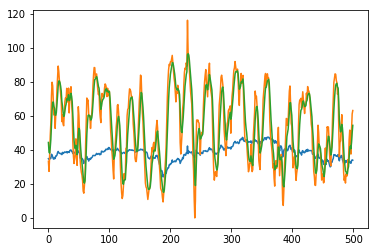

In [13]:
plt.plot(qclose[0:500])
plt.plot(qkdjk[0:500])
plt.plot(qkdjd[0:500])